In [1]:
import re
import subprocess
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/ATAC_CTCF/modules/")
import tf_memory_limit
from keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
import ctcfdhsgen
from keras.models import load_model
from scipy.signal import correlate2d
from convnet import Bias
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve

meme_path = '/home/kal/data/CTCF.meme'

Using TensorFlow backend.


In [2]:
old_model = load_model('/home/kal/CTCF/mass_CTCF/eric_output/20170814_163533/20170814_163533_weights_3_243_0.91.hdf5', custom_objects={'Bias':Bias})
old_layer_dict = dict([(layer.name, layer) for layer in old_model.layers])

reg_model = load_model('/home/kal/CTCF/mass_CTCF/output/20170804_121119/20170804_121119_weights_3_248_50749.38.hdf5', custom_objects={'Bias':Bias})

In [3]:
batch_size=32
input_window=256

model_dir = '/home/kal/CTCF/ATAC_CTCF/output/20170815_115609/'
gen_path='/home/kal/CTCF/ATAC_CTCF/data/ctcfdhs_generator.hdf5'

# load the model
# load the potential model paths
model_paths = list()
for file in os.listdir(model_dir):
    if 'weights_' in file and file.endswith(".hdf5"):
        model_paths.append(os.path.join(model_dir, file))
# Find the model with the lowest val_loss
def extract_number(f):
    s = f.split('_')[-1].rsplit('.', maxsplit=1)
    return (-float(s[0]) if s else -1, f)
model_path = max(model_paths, key=extract_number)
print('model path:' + str(model_path))
model = load_model(model_path, custom_objects={'Bias':Bias})
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# load the generator
gen = ctcfdhsgen.CTCFGeneratorhdf5(gen_path)

model path:/home/kal/CTCF/ATAC_CTCF/output/20170815_115609/20170815_115609_weights_2_05_6404.97.hdf5


In [4]:
def group_stats(key, h1, h2, h3):
    # Summarize history for accuracy
    out1 = np.copy(h1[key])
    out2 = np.copy(h2[key])
    out3 = np.copy(h3[key])
    return np.concatenate([out1, out2, out3])

In [5]:
# load the historys
num_pk1 = len([f for f in os.listdir(model_dir) if f.endswith('.pk1') and os.path.isfile(os.path.join(model_dir, f))])
folder_name = os.path.basename(os.path.normpath(model_dir))
history_path = os.path.join(model_dir, folder_name + '_history')
if num_pk1 == 1:
    with open(history_path + '1.pk1', 'rb') as input:
        h = pickle.load(input)
        finer_epochs = False
elif num_pk1 == 3:
    with open(history_path + '1.pk1', 'rb') as input:
        h1 = pickle.load(input)
    with open(history_path + '2.pk1', 'rb') as input:
        h2 = pickle.load(input)
    with open(history_path + '3.pk1', 'rb') as input:
        h3 = pickle.load(input)
    finer_epochs = True

print('Loaded training history.')

Loaded training history.


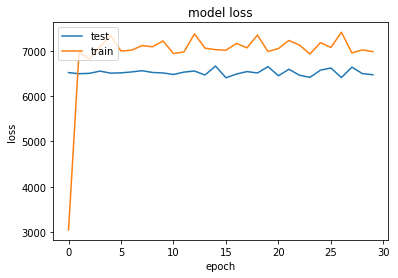

In [6]:
# plot the loss
key='loss'
if finer_epochs:
    plt.plot(group_stats('val_' + key, h1, h2, h3))
    plt.plot(group_stats(key, h1, h2, h3))
else:
    plt.plot(h[key])
    plt.plot(h['val_' + key])
plt.title('model '+ key)
plt.ylabel(key)
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')
plt.savefig(os.path.join(model_dir, 'model_' + key + '.png'), bbox_inches='tight')
plt.show()

In [7]:
# process the memes
with open(meme_path, 'r') as infile:
    meme_length = -1
    CTCF_memes = list()
    for line in infile.readlines():
        if 'letter-probability matrix' in line:
            meme_length = int(line.split()[5])
            this_meme_lines = list()
        elif meme_length > 0:
            this_meme_lines.append([float(item.strip()) for item in line.split()])
            meme_length = meme_length - 1
        elif meme_length == 0:
            this_meme = np.asarray(this_meme_lines)
            CTCF_memes.append(this_meme)
            meme_length = -1
    if meme_length == 0:
        this_meme = np.asarray(this_meme_lines)
        CTCF_memes.append(this_meme)
        meme_length = -1

# add rcs of memes
rcs = list()
for meme in CTCF_memes:
    rcs.append(meme[::-1, ::-1])
CTCF_memes = CTCF_memes + rcs

psuedocount=0.1
# get the transformed memes
transformed_memes = list()
for meme in CTCF_memes:
    meme = meme + psuedocount
    norms = np.repeat(np.linalg.norm(meme, axis=1), 4).reshape((-1, 4))
    meme = np.log(meme/norms)
    min = np.amin(meme)
    meme = meme - min
    transformed_memes.append(meme)

def get_pwm_score(input_seqs, meme_library=transformed_memes):
    scores = list()
    for seq in input_seqs:
        best_score = -np.inf
        for test_meme in meme_library:
            correlations = correlate2d(seq, test_meme, mode='valid')
            if np.max(correlations) > best_score:
                best_score = np.max(correlations)
                best_location = np.argmax(correlations)
                best_filter = test_meme
        scores.append(best_score)
    return np.asarray(scores)

In [8]:
g = gen.batch_gen(mode='test', log=False)
num_samples = len(np.asarray([str(key) for key in gen.hf5['test'].keys()]))
print(num_samples)
preds = list()
scores = list()
pwms = list()
old_preds = list()
reg_preds = list()
get_act = K.function([old_model.input, K.learning_phase()], [old_layer_dict['bias'].output])
for (batch, labels), index in zip(g, range(num_samples // batch_size)):
    # Get predicitons and ctcf scores
    #preds.append(model.predict(batch).flatten())
    preds.append(model.predict([batch[:,:,:4], batch[:,:,4:5]]).flatten())
    scores.append(labels)
    # get pwm scores
    pwms.append(get_pwm_score(batch))
    # get old model scores
    old_batch = np.asarray(batch)[:, :, :4]
    old_preds.append(np.array(get_act([old_batch, 0])).flatten())
    reg_preds.append(reg_model.predict(old_batch).flatten())

preds = np.asarray(preds).flatten()
scores = np.asarray(scores).flatten()
pwms = np.asarray(pwms).flatten()
old_preds = np.asarray(old_preds).flatten()
reg_preds = np.asarray(reg_preds).flatten()

29220


0


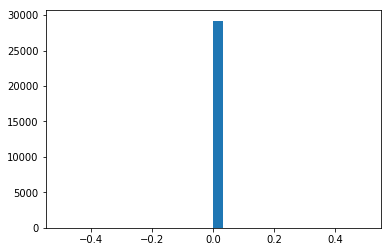

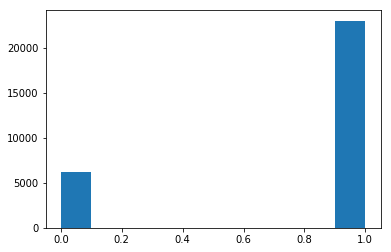

In [9]:
labels = [score>0 for score in scores]
print(np.amin(scores))
plt.hist(preds, bins=30)
plt.show()
plt.hist(labels)
plt.show()

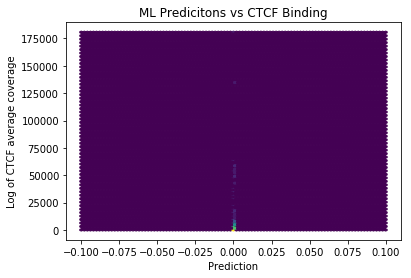

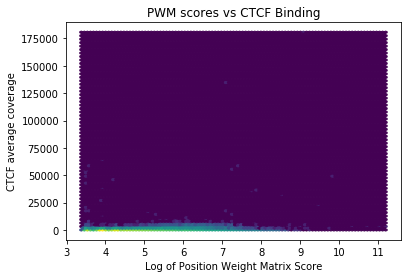

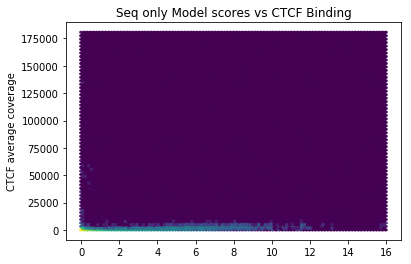

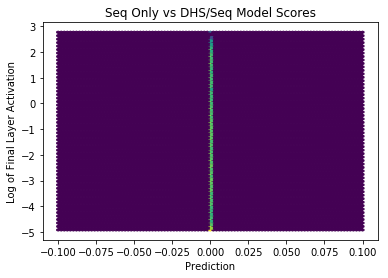

In [10]:
plt.hexbin(preds, scores, bins='log')
plt.title('ML Predicitons vs CTCF Binding')
plt.xlabel('Prediction')
plt.ylabel('Log of CTCF average coverage')
plt.show()

plt.hexbin(np.log(pwms), scores, bins='log')
plt.title('PWM scores vs CTCF Binding')
plt.xlabel('Log of Position Weight Matrix Score')
plt.ylabel('CTCF average coverage')
plt.show()

plt.hexbin(old_preds, scores, bins='log')
plt.title('Seq only Model scores vs CTCF Binding')
plt.ylabel('Final Layer Activation')
plt.ylabel('CTCF average coverage')
plt.show()

plt.hexbin(preds, np.log(old_preds), bins='log')
plt.title('Seq Only vs DHS/Seq Model Scores')
plt.xlabel('Prediction')
plt.ylabel('Log of Final Layer Activation')
plt.show()

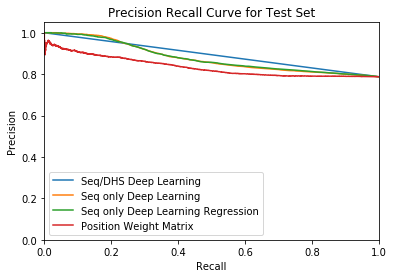

In [11]:
# plot a pr curve
mlp, mlr, thresholds = precision_recall_curve(labels, preds, pos_label=1)
pwmp, pwmr, thresholds = precision_recall_curve(labels, pwms, pos_label=1)
omlp, omlr, thresholds = precision_recall_curve(labels, old_preds, pos_label=1)
rmlp, rmlr, thresholds = precision_recall_curve(labels, reg_preds, pos_label=1)

plt.plot(mlr, mlp, label='Seq/DHS Deep Learning')
plt.plot(omlr, omlp, label='Seq only Deep Learning')
plt.plot(rmlr, rmlp, label='Seq only Deep Learning Regression')
plt.plot(pwmr, pwmp, label='Position Weight Matrix')
plt.legend()
plt.title('Precision Recall Curve for Test Set')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

Proportion positive:0.787308324206


/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in double_scalars


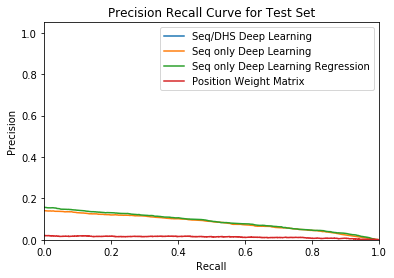

In [12]:
prop_pos = sum(labels)/len(labels)
print('Proportion positive:' + str(prop_pos))
def gain(data):
    return [(x-prop_pos)/((1-prop_pos)*x) for x in data]
mlpg = gain(mlp)
mlrg = gain(mlr)
pwmpg = gain(pwmp)
pwmrg = gain(pwmr)
omlrg = gain(omlr)
omlpg = gain(omlp)
rmlrg = gain(rmlr)
rmlpg = gain(rmlp)

plt.plot(mlrg, mlpg, label='Seq/DHS Deep Learning')
plt.plot(omlrg, omlpg, label='Seq only Deep Learning')
plt.plot(rmlrg, rmlpg, label='Seq only Deep Learning Regression')
plt.plot(pwmrg, pwmpg, label='Position Weight Matrix')
plt.legend()
plt.title('Precision Recall Curve for Test Set')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

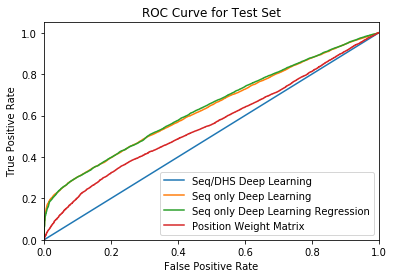

In [13]:
# plot a roc curve
mlr, mlp, thresholds = roc_curve(labels, preds, pos_label=1)
pwmr, pwmp, thresholds = roc_curve(labels, pwms, pos_label=1)
omlr, omlp, thresholds = roc_curve(labels, old_preds, pos_label=1)
rmlr, rmlp, thresholds = roc_curve(labels, reg_preds, pos_label=1)

plt.plot(mlr, mlp, label='Seq/DHS Deep Learning')
plt.plot(omlr, omlp, label='Seq only Deep Learning')
plt.plot(rmlr, rmlp, label='Seq only Deep Learning Regression')
plt.plot(pwmr, pwmp, label='Position Weight Matrix')
plt.legend()
plt.title('ROC Curve for Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# 